# Plot model output
## Explore NetCDF output variables produced by a successful model run
This notebook is heavily inspired by https://github.com/NCAR/ctsm_python_gallery, https://mpaiao.github.io/FATES_Utils/index.html, and https://fates-users-guide.readthedocs.io/en/latest/index.html.

It is important to note that this code was written for specific versions of CLM (GitHub release tag: `ctsm5.1.dev090`) and FATES (GitHub release tag: `sci.1.55.4_api.22.1.0`), and for the specific output produced by the NorESM-LSP without customizing the underlying model code. When the CESM community updates the models, they often change or add variables, which means that you also need to update the variable names within this analysis.

**Read the instructions carefully. Unless stated otherwise, make sure to execute all code cells in sequential order. The parts of this notebook focussing on model-data integration are only automated for the Vestland Climate Grid sites (see documentation).**

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path

---
### Define names and path to the NetCDF output

**Attention! By default, the model produces many seperate output files (one per month). You should concatenate them using the [combine_nc_files.ipynb](../../notebooks/combine_nc_files.ipynb) notebook to facilitate and speed up the analysis.**

_Execute the next cell to display available case names/site IDs in the current version of the NorESM-LSP(optional)._

In [2]:
with open("/home/jovyan/config/sites.json", 'r', encoding='utf-8') as lsp_sites_json:
    lsp_sites_dict = json.load(lsp_sites_json)
    
print(f"{'Case name':>9}{'Long name':>25}")
print('-'*34)
_ = [print(f"{cur_site['properties']['name']:>9}{cur_site['properties']['long_name']:>25}") for cur_site in lsp_sites_dict['features']]

Case name                Long name
----------------------------------
     ALP1               Ulvehaugen
     ALP2              Laavisdalen
     ALP3               Gudmedalen
     ALP4         Skjellingahaugen
     SUB1                  Aalrust
     SUB2                 Hoegsete
     SUB3                 Rambaera
     SUB4                   Veskre
     BOR1                   Fauske
     BOR2                Vikesland
     BOR3               Arhelleren
     BOR4                Oevstedal
      ISK                  Iskoras
     HIS1              Hisaasen_up
     HIS2             Hisaasen_low
      HUR                   Hurdal
      FNS          Finse_fluxtower
      BYV                  Bayelva
      ADV              Adventdalen
      AAS                      Aas


In [3]:
# Add the full case name in quotation marks here! E.g.: "5994e825658b853b95d61feccffd18ad_bor1-1000y"
case_name = "5994e825658b853b95d61feccffd18ad_bor1-1000y"

# Enter the case ID (aka. short site code, see table above) in quotation marks here! E.g.: "BOR1".
# ATTENTION! This is case sensitive and important to find the right paths: use the correct capitalization of letters!
case_id = "BOR1"

# Path to the case's land archive output, i.e. the folder containing the `.nc` file(s) you want to analyse. 
# Only change this line if you renamed/moved the folder or moved files from the default location!
output_data_path = Path(f"/home/jovyan/cases/{case_name}/archive/lnd/")

### Enter the name(s) of the output file(s) - READ CAREFULLY!

In the likely case that you produced multiple output files, we recommend to concatenate these into a single file (see above). However, if you want to combine multiple files 'on the fly', you can uncomment the respective line in the next code cell and adapt it accordingly - note that this process can take a long time!

You can use the analysis examples in this notebook as a template for analysing other history tapes, which you must have defined in the GUI when creating the case. Make sure to give the correct name (i.e. `h1`, `h2`, etc.) and that the variables you want to analyse are included in it.

In [4]:
# Enter the name of a single output file, e.g. created with the 'combine_nc_files' notebook. For example:
file_path = f"{output_data_path}/5994e825658b853b95d61feccffd18ad_bor1-1000y.h0.0001-1000.nc"

# Optional: enter name to read in multiple output files
# The following line uses '*' wild card notation to combine all files from a given history tape on the fly
# file_path = f"{output_data_path}/hist/*h0*.nc"  # Example for reading in multiple files at once, i.e. all in the given folder for history tape zero

In [5]:
# Read data, normally no need to change
output_nc_data = xr.open_mfdataset(file_path,
                                   combine='by_coords',
                                   decode_times=True
                                  )

### Create/define folder for the case's output plots

In [6]:
# Only change if you want to use a non-default location
plot_save_path = Path().absolute() / case_name

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

### Data set exploration
There are different ways to explore your model output dataset. The code cell below prints relevant information about the NetCDF file(s) you specified above using the `xarray` package functionalities. Alternatively, you can open [Panoply](http://localhost:5800/), which we include as a seperate service in the NorESM-LSP for convenience (see NorESM documentation). Panoply is ideal if you want to get a quick overview of all output variables: you can browse them in a list and easily create plots via an interactive Graphical User Interface. You simply need to navigate to your output directory at the top (by default contained in `/resources/cases/your_case_id`) to load in the data. Additional details about its full functionalities and usage instructions can be found [here](https://www.giss.nasa.gov/tools/panoply/).

In [7]:
# Print full dataset information
output_nc_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 156,
                                       fates_levcacls: 2, fates_levcapf: 24,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 12, fates_levfuel: 6,
                                       ...
                                       fates_levscagpf: 1092,
                                       fates_levagepft: 84,
                                       fates_levagefuel: 42, time: 12000,
                                       hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/14)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levpft                      (fates_levpft) int32 1 2 3 4 ... 10 11 12
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * time                              (time) object 0001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, hist_interval, lndgrid,
                                fates_levelem, fates_levelcwd, glc_nec, ltype
Data variables: (12/495)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(12000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Tue Aug 30 13:05:04 2022: ncrcat /h...
    source:                               Community Terre

If you want to learn more about the structure of NetCDF files, you may find [this introduction summary](https://adyork.github.io/python-oceanography-lesson/17-Intro-NetCDF/index.html) helpful.

---
# Create simple time series line plots
##### Plot variables with only time and lndgrid dimensions.
There are multiple ways to create output plots from xarray `DataArray` objects, i.e., for all the variables contained in the full xarray `DataSet` that we created when reading in the NetCDF files. For more details, check https://docs.xarray.dev/en/latest/user-guide/plotting.html.

Let's start by selecting one of the `Data variables` from the output above that only has `time` and `lndgrid` dimensions (listed in the parentheses in the second column when you display the data).

In [17]:
var_name = "FATES_VEGC_ABOVEGROUND" # "FATES_AREA_TREES", "FATES_GPP", "SNOW"...

Next, explore your choice by assigning the specific variable object to a new Python variable name and by printing its content.

In [18]:
var = output_nc_data[var_name]
var

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND' (time: 12000, lndgrid: 1)>
dask.array<open_dataset-5ecc5bc1ed0129148d24d2154757d0a3FATES_VEGC_ABOVEGROUND, shape=(12000, 1), dtype=float32, chunksize=(12000, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 1001-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      aboveground biomass in kg carbon per m2 land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

---
The simplest way to create a plot is to use the `plot()` method that is already built into `DataArray`s. This approach is great for quick exploration, but experienced Python users may prefer the known interface and full flexibility of `matplotlib`, which we will use afterwards.

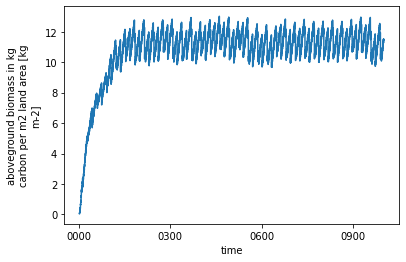

In [19]:
# Directly call the DataArray's plot method
var.plot()

As you see, this method automatically detects the internal structure of the data (2D-line plot) and assigns sensible values and labels to the axes (i.e., simulation dates and variable long name including unit). It is also possible to provide additional arguments to the function call to adapt the plot, see [here](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html#xarray.DataArray.plot) for details.

You can also create plots with other packages by accessing the object's values directly, e.g., with the popular `matplotlib` library. Note that the `DataArray.plot()` method also uses this library "under the hood".

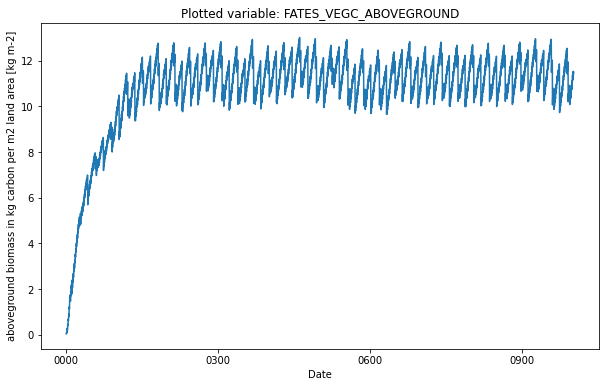

In [21]:
# Create the same plot using matplotlib library directly
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(output_nc_data['time'], var)
ax.set_title(f"Plotted variable: {var_name}")
ax.set_xlabel("Date")
ax.set_ylabel(f"{var.long_name} [{output_nc_data[var_name].units}]");

---
# Plotting variables with more dimensions
We will now create plots for a variable with more dimensions, namely `FATES_VEGC_PF`, which stores the amount of total biomass in kg of carbon per land area for each included PFT.

In [22]:
# Variable name for biomass per PFT in dataset
var_name = "FATES_VEGC_PF"

Start by again calling the internal `DataArray.plot()` method.

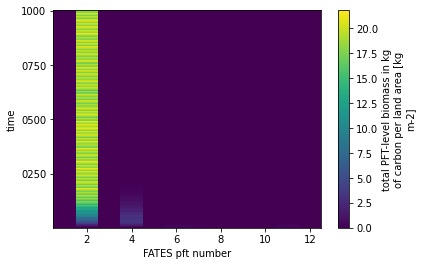

In [23]:
pft_biomass = output_nc_data[var_name]
pft_biomass.plot()

Here the plot the default method generates is arguably not ideal to display the output. We will hence create a customized multi-line plot and provide custom labels.

---
The following cell reads and defines some FATES PFT properties as Python `dict`(ionary) objects that we will use for plotting.

In [24]:
"""
Load and create dictionaries defining PFT and plot properties.
NB: this is version and model setting dependent!
The 'fates_pft_dict' keys are the PFT indices used in the FATES output.
"""

with open("/home/jovyan/notebooks/model_output_analysis/dicts/default_fates_pfts.json", 'r', encoding='utf-8') as fates_pft_json:
    fates_pft_dict = json.load(fates_pft_json)

pft_group_plot_dict = {
    "tree": {
        "linestyle": "-"
    },
    "shrub": {
        "linestyle": "--"
    },
    "grass": {
        "linestyle": ":"
    }
}

<h3 style="color:red;">NB! Did you use non-default PFT indices?</h3>
If you changed the number of PFTs for your simulation, you need to adjust the following code. I.e., you need to enter the same list of PFT indices you used when you created the case in the GUI:

1. Open the GUI window/tab (localhost:8080) and click on the site name, either using the map or the overview at the top
2. Under `Cases`, search for the case ID you are analyzing here
3. Click on ___See Variables___
4. Copy the list of integers displayed for `included_pft_indices` into the `custom_pft_indices` variable in the code cell below
5. Set the value for `use_custom_pfts` to `True`

In [29]:
# ADJUST HERE
use_custom_pfts = False  # True or False

if use_custom_pfts:
    custom_pft_indices = [  # Add the comma-seperated list of PFT indices below. OBS! Do not remove the square brackets!
        7, 8, 9, 10, 11
    ]

    # NO NEED TO TOUCH THE FOLLOWING LINES #
    # Create new dict for included PFTs from default
    custom_pft_dict = {str(idx+1): fates_pft_dict[str(pft_idx)] for idx, pft_idx in enumerate(custom_pft_indices)}
    custom_pft_dict

In [30]:
# Display variable details
pft_biomass

<xarray.DataArray 'FATES_VEGC_PF' (time: 12000, fates_levpft: 12, lndgrid: 1)>
dask.array<open_dataset-5ecc5bc1ed0129148d24d2154757d0a3FATES_VEGC_PF, shape=(12000, 12, 1), dtype=float32, chunksize=(12000, 12, 1), chunktype=numpy.ndarray>
Coordinates:
  * fates_levpft  (fates_levpft) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * time          (time) object 0001-02-01 00:00:00 ... 1001-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      total PFT-level biomass in kg of carbon per land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

Let's now use Matplotlib again to create a multi-line plot to depict the PFT biomass dynamics in a more tangible way. Note that you can also achieve a similar result with the built-in `DataArray.plot()` method by providing additional arguments (see documentation).

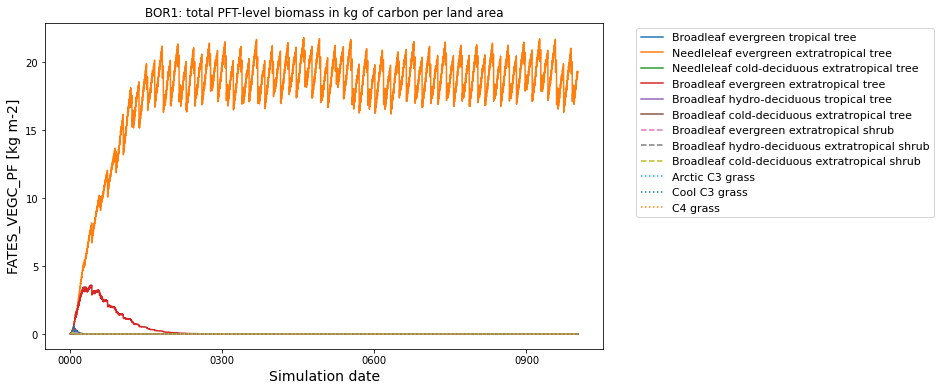

In [33]:
# Instantiate plot
fig, ax = plt.subplots(figsize=(10,6))

# Create a multi-line plot by looping through PFT properties
plot_handle_list = []

# Determine whether default or customized PFTs were used based on boolean variable
pft_dict = custom_pft_dict if use_custom_pfts else fates_pft_dict

for cur_pft_idx in pft_biomass.fates_levpft:
    
    cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
    
    # Plot biomass for current PFT index
    cur_plot_handles, = ax.plot(output_nc_data['time'],
                                pft_biomass.sel(fates_levpft=cur_pft_idx),
                                label=cur_pft_dict["long_name"],
                                linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                linewidth=1.5
                               )
    
    plot_handle_list.append(cur_plot_handles)

# Set overall plot layout
ax.set_title(f"{case_id}: {pft_biomass.long_name}")
ax.set_xlabel("Simulation date", fontsize=14)
ax.set_ylabel(f"{var_name} [{pft_biomass.units}]", fontsize=14)

ax.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
);

Note that this plot shows the **total PFT-level biomass**, ergo the sum of the biomass of the same PFTs across all simulated patches, scaled to kg/m².

---
# `runtype = startup` - the simulation spin-up period

After we have learned how to read the data and how to create output plots while taking the differences in variable dimensions into account, we now want to focus on explaining what we see. One notorious challenge when using earth system models is the computationally expensive **spin-up phase**. When choosing `runtype=startup` in the model settings, which is the NorESM-LSP default, we start the model from a so-called "bare ground" state: the simulation commences from bare soil without any vegetation and empty carbon pools (soil, litter, etc.). In the beginning, fast-growing pioneer PFTs (e.g. grasses or fast growing trees) may thrive that may later become less dominant or disappear due to the competition with slower growing plants, e.g. specific tree PFTs. Consequently, model results that did not undergo a sufficiently long spin-up period should usually be considered invalid.

The spin-up period computational load can be maneageable for single-site simulations, but it gets more difficult the larger the simulated area is and the more model components you include. In CLM-FATES, the starting conditions are chiefly controlled by the `runtype` parameter - depending on its value, additional files and parameter changes may be required. For example, it is also possible to use a previous spin-up simulation as a starting point for other modelling experiments, which is currently not implemented in the NorESM-LSP's GUI.

Let's create plots to investigate some important state variables over our chosen simulation period.

_The following plots are inspired by the CTSM analysis tool mentioned [here](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/running-special-cases/Spinning-up-the-biogeochemistry-BGC-spinup.html)._

In [ ]:
# Use this cell to explore the variables defined below, if you want. E.g.:
# output_nc_data["TWS"]

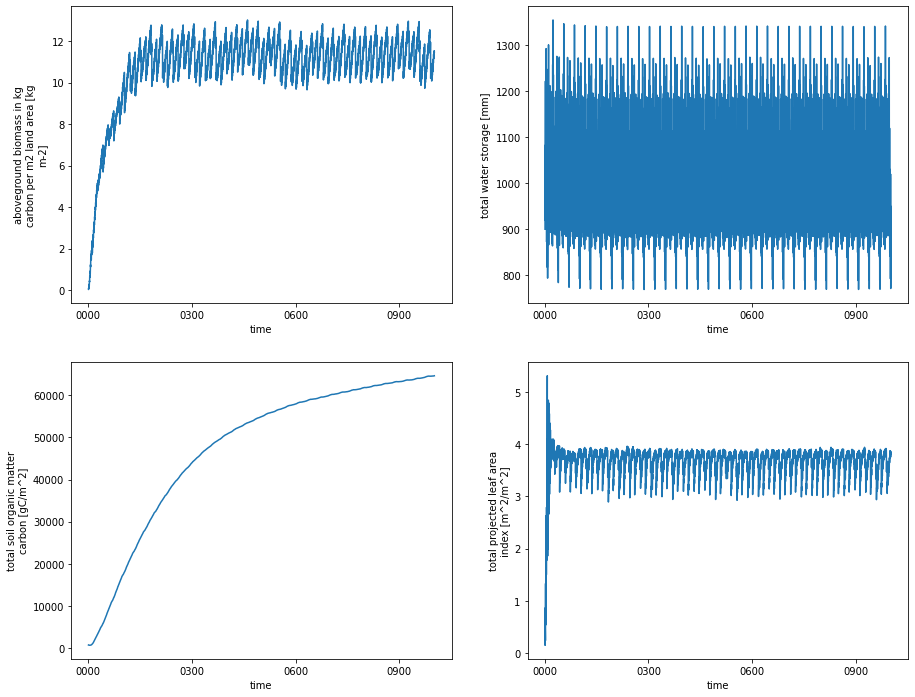

In [34]:
import math

# Variables to plot from 'output_nc_data', feel free to add more names to the list
var_names = ["FATES_VEGC_ABOVEGROUND", "TWS", "TOTSOMC", "TLAI"]

# Instantiate figure with subplot grid adapted to number of variables provided
fig, axes = plt.subplots(
    nrows=math.ceil(len(var_names)/2),
    ncols=2,
    figsize=(15, math.ceil(len(var_names)/2)*6)
)

# Delete empty axis object if number of variable names in list is odd
if len(axes.flatten()) != len(var_names):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# Plot all variables
for ax, var in zip(axes.flatten(), var_names):
    output_nc_data[var].plot(ax=ax)

If you used `runtype=startup` for your simulation, you should see that the values in the plots above start around 0 (bare ground), subsequently start increasing, and for sufficiently long periods stabilize over time: the vegetation and carbon pools reach an equilibrium state. The variables still fluctuate due to model processes (such as disturbances and dying PFTs) and climatic variabilities, but the magnitudes and "overall patterns" do not change drastically anymore. Some state variables such as the soil carbon pool can take particularly long until they reach equilibrium due to the slow nature of the involved processes (decomposition, litter buildup, etc.).

---
# Carbon fluxes

A classic application for DGVMs is to investigate climate-vegetation interactions with respect to plants' crucial role in the carbon cycle. Accordingly, there are many ways to analyze how carbon "moves" between the different components of the models, e.g. between land and atmosphere. Let's explore some total (summed across PFTs and patches) annual C fluxes in the single-site simulation over time.

ADD EXAMPLE FOR PLANT ORGANS PER PFT.

In [37]:
# Display data again to investigate variables related to C fluxes
output_nc_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 156,
                                       fates_levcacls: 2, fates_levcapf: 24,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 12, fates_levfuel: 6,
                                       ...
                                       fates_levscagpf: 1092,
                                       fates_levagepft: 84,
                                       fates_levagefuel: 42, time: 12000,
                                       hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/14)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levpft                      (fates_levpft) int32 1 2 3 4 ... 10 11 12
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * time                              (time) object 0001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, hist_interval, lndgrid,
                                fates_levelem, fates_levelcwd, glc_nec, ltype
Data variables: (12/495)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(12000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Tue Aug 30 13:05:04 2022: ncrcat /h...
    source:                               Community Terre

In [52]:
# Names of the variables that represent important C fluxes
# It is possible to add new variable names to the list (plots will be added automatically)
c_flux_var_names = ["FATES_VEGC_ABOVEGROUND", "FATES_NPP", "FATES_NEP", "FATES_GPP", "CH4PROD", "FATES_AUTORESP"]
c_flux_vars = [output_nc_data[s] for s in c_flux_var_names]

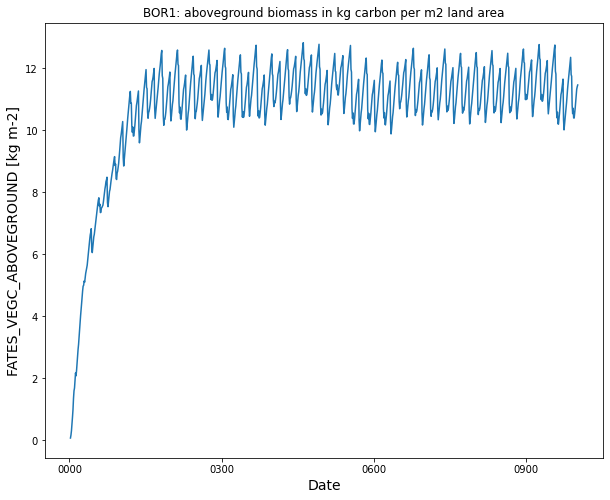

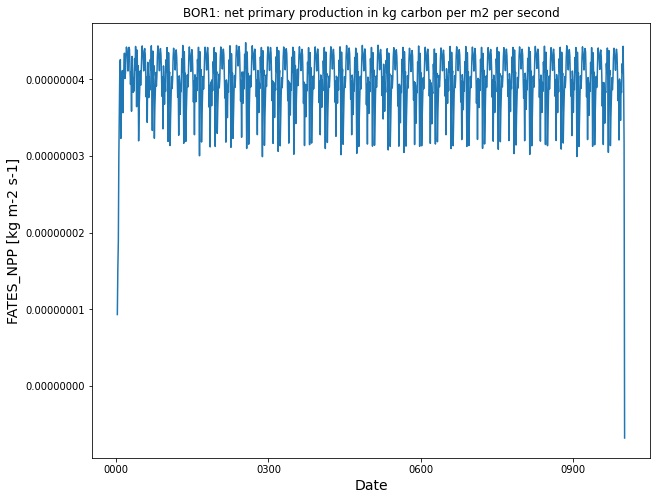

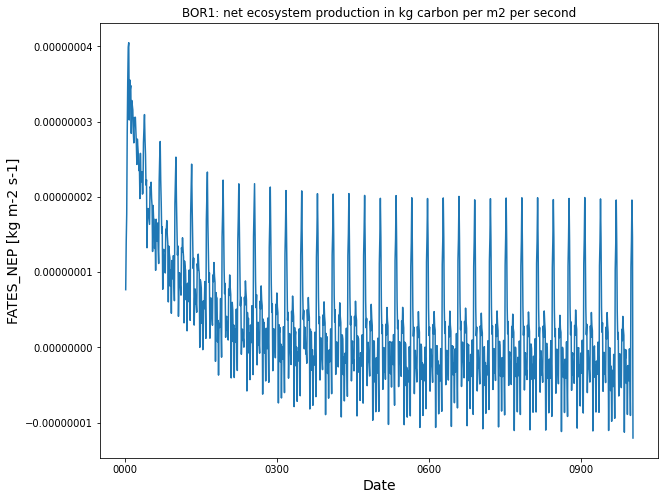

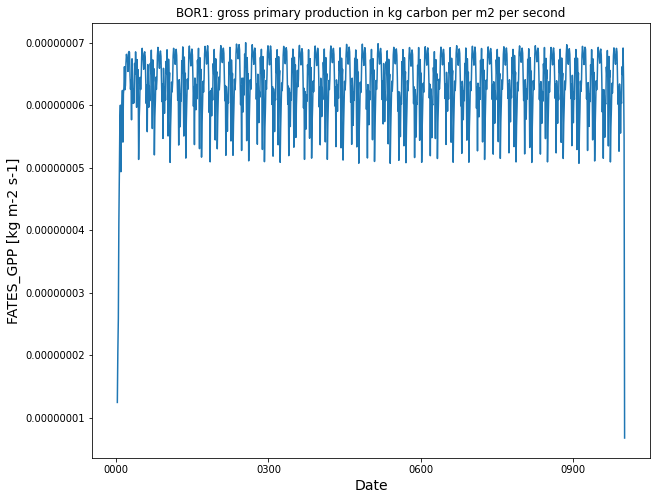

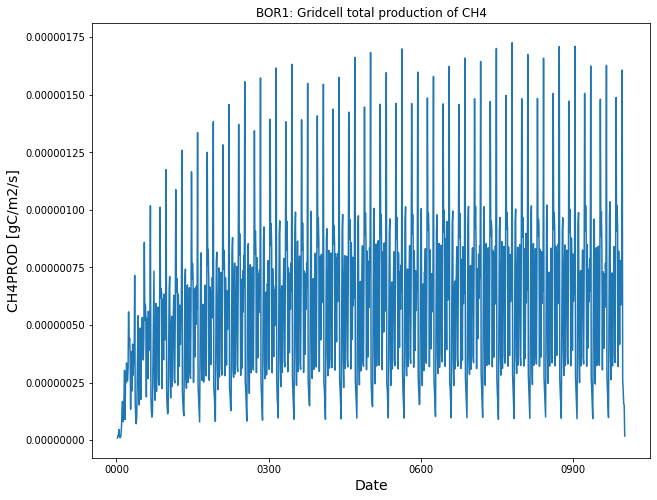

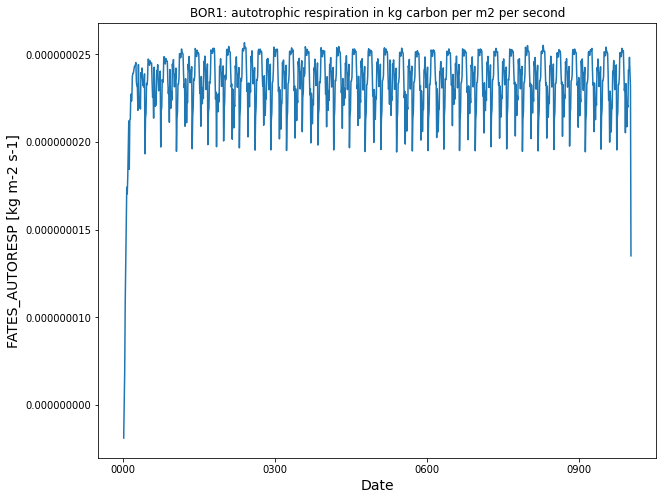

In [53]:
for c_var in c_flux_vars:
    fig, ax = plt.subplots(figsize=(10,8))
    
    c_var_annual = c_var.resample(time='1Y').mean()
    
    #cur_plot_handle, = \
    ax.plot(c_var_annual['time'], c_var_annual, label=c_var.long_name.capitalize())

    ax.set_title(f"{case_id}: {c_var.long_name}")
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(f"{c_var.name} [{c_var.units}]", fontsize=14)
    
    # Use plain notation, i.e., avoid scientific "1e-3" notation
    ax.ticklabel_format(style='plain', axis='y')
    
    """
    ax.legend(
        #handles=cur_plot_handle,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=14
    )
    """

---
# FATES patches
To better understand some important subgrid processes in the model, we will now analyze the output grouped by different properties of the modelled vegetation. First, we focus on the concepts of "age bins" and "patches". **NB**! The next code cells only work if you have successfully included the `NPATCH_BY_AGE` variable in the output for history tape 0 (`hist_fincl0` -> `NPATCH_BY_AGE`) as it is not included by default (see https://escomp.github.io/ctsm-docs/versions/master/html/users_guide/setting-up-and-running-a-case/master_list_fates.html).

🤔 **Question 8**:
Skim the following documentation: https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/DGVM/CLM50_Tech_Note_DGVM.html#the-representation-of-ecosystem-heterogeneity-in-fates. In this model, what is a patch? What is a cohort? What is a height class? How and why are patches and cohorts merged?

In [ ]:
npatch_by_age = output_nc_data["NPATCH_BY_AGE"]
npatch_by_age

---
As usual, let's explore the standard plot first.

In [ ]:
npatch_by_age.plot()

In [ ]:
# Explore the 'fates_levage' variable
npatch_by_age.fates_levage

In [ ]:
# Make a list for labelling the legend in a more comprehensive way
vals = list(npatch_by_age.fates_levage.values)

age_labels = [str(int(vals[x]))+"-"+str(int(vals[x+1])) if x+1!=len(vals) else ">"+str(int(vals[x])) for x in range(len(vals))]
age_labels

#### Multi-line plot

In [ ]:
# Instantiate plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create a multi-line plot by looping through PFT properties
plot_handle_list = []

for iter_idx, cur_age_idx in enumerate(npatch_by_age.fates_levage):
    
    #cur_pft_dict = pft_dict[str(int(cur_age_idx))]
    
    # Plot biomass for current PFT index
    cur_plot_handles, = ax.plot(output_nc_data['time'],
                                npatch_by_age.sel(fates_levage=cur_age_idx),
                                label=age_labels[iter_idx],
                                #linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                linewidth=1.5
                               )
    
    plot_handle_list.append(cur_plot_handles)

# Set overall plot layout
ax.set_title(f"{case_name}: {npatch_by_age.long_name}")
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel(f"Number of patches", fontsize=14)

ax.legend(
    title="Age bin [years]",
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

In [ ]:
patch_area_by_age = output_nc_data['PATCH_AREA_BY_AGE']

fig, ax = plt.subplots(figsize=(8, 8))

color_bar_plot = \
patch_area_by_age.T.plot(ax=ax,
                         cbar_kwargs={
                             'label': r'Patch Area by Age (m$^2$ patch m$^{-2}$ site)'
                             }
                        )


# Title and labels
ax.set_title(f"{case_name}: {patch_area_by_age.long_name}")
ax.set_ylabel("Age bin [years]", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylim(0, 20)  # We are only simulating 10 years and can ignore the higher age bins
ax.set_yticks([0, 5, 10, 15, 20])

---
# Integrating model input/output and observations -> MOVE THIS TO NEW NOTEBOOK TO PRODUCE PAPER RESULTS

This is an example to relate the model output to available observational data. Comparing ecological observations to LSM/DGVM output is a notoriously challenging task. It includes:

- Harmonizing temporal and spatial scales (aggregated grid cell resolutions (km) vs. local observations (cm-m), decade to century scale simulations vs. few year observational studies, etc.)
- Different languages and foci of the scientific disciplines involved (biologists _vs._ geoscientists _vs._ computer scientists _vs._ ...)
- Data access and documentation

Accordingly, a main goal of the NorESM modelling platform is to improve the mutual understanding among ecological data collectors and the land surface modelling community. In addition to giving people easier access to running simulations, it aims at showcasing and facilitating how field observations can be used to both constrain the model input and validate its output. The `Vestland Climate Grid` sites you can choose within the GUI provide datasets for various 'classical' ecological experiments. As a practical example, we will now extract some of their measurements for 'soil temperature' and check how it compares to the modelled counterpart in the CLM-FATES simulation. However, note that due to the time mismatch between the available observational data and the climate forcing data set we are providing in the first NorESM-LSP release ([GSWP3](https://www.isimip.org/gettingstarted/details/4/)), we will not be able to compare the exact same points in time - but it does give us an idea if the model somewhat realistically represents the observed patterns.

This example further highly benefits from the fact that the VCG data follows the FAIR principles. We can directly access it from OSF and attain a fully reproducible, well documented workflow. 

## Example: soil temperature

In [ ]:
# Soil temperature history variable in CLM
var_name = "TSOI"

In [ ]:
t_soil = output_nc_data[var_name]
t_soil

In [ ]:
# Explore the standard output plot to get a better feeling for the data
t_soil.plot()

In [ ]:
# Convert from Kelvin to Celsius
t_soil_celsius = t_soil - 273.15

In [ ]:
# Investigate the included ground levels. See:
# https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#id17

t_soil_celsius.levgrnd

#### Exploring sources of uncertainty in the input data
By setting the `use_bedrock` flag to `True`, we are telling the model to use a variable soil depth rather than using a default value (e.g., remember how LPJ-GUESS Education uses a globally uniform 1.5 m soil column). See for example [this GH issue](https://github.com/NGEET/fates/pull/381) for additional information and associated discussions. The soil depth observations in the current version of the NorESM landsites platform input data were interpolated from a global soil map (see `input_visualization.ipynb` for details). Let's investigate if this data is appropriate for our study design.

In [ ]:
# Open the surface data file included in the standard input data
surface_dset = xr.open_dataset(
    f'../../data/{case_id}/inputdata/lnd/clm2/surfdata_map/{case_name}/surfdata_{case_name}_simyr2000.nc'
)
# Print
surface_dset

Print information about the soil depth as contained in the default input data. More information [here](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#depth-to-bedrock).

In [ ]:
display(surface_dset['zbedrock'])
print("Default soil depth in surface data [m]: ", float(surface_dset['zbedrock']))

This is an example how we can use _in situ_ observational data to constrain the model **input**: we could use soil depth measurements from the site to directly manipulate the input surface data NetCDF file.

---
In addition, even though our goal is to focus the "single-point" simulation to a somewhat homogenous, terrestrial, vegetated ecosystem, the default methods of creating the input data will also assign other land cover classes to the modelled locality. Explore the output below. Note that the values for percent PFT do not apply to our simulation as we used FATES. 

In [ ]:
for var_name in list(surface_dset.keys()):
    if var_name.startswith("PCT"):
        print(f"{var_name} - {surface_dset[var_name].long_name}:\n\n{surface_dset[var_name]}\n{'-'*70}\n")

Depending on the questions we seek to answer, we therefore also might need to further adjust the input data and model setup - or be at least aware of the limitations and uncertainties the forcing may introduce. Note that we plan to include optimized versions of the input data including different climate forcing sources in future releases of the platform. This is also a great example of how complicated the interdisciplinary communication between new users and model developers can be - there are many, many details that can impact your results!

---
Let's get back to the modelled soil temperature. Note how we here now combine the two previous ways of creating plots, thereby making use of `xarray`'s built-in convenience methods and direct manipulation of the `matplotlib` plot objects.

In [ ]:
# Define max depth to investigate top soil/ground layers
max_depth = 15  # [m]
bool_mask = t_soil_celsius.levgrnd < max_depth

# Infer integer index until which condition is met, warning: very unsafe approach that only works because data is ordered in a certain way
soil_idx = bool_mask.values.sum() - 1
# Subset data
t_soil_15m = t_soil_celsius.isel(levgrnd=slice(0, soil_idx))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

color_bar_plot = t_soil_15m.T.plot(ax=ax, 
                                   cbar_kwargs={
                                       'label': "Soil temperature [°C]"
                                   })

# Make plot more intuitive by setting depth=0 to the top
ax.invert_yaxis()

# Title and labels
ax.set_title(f"{case_name}: modelled soil and ground temperature")
ax.set_ylabel("Depth [m]", fontsize=14)
ax.set_xlabel("Date", fontsize=14)

---

Next, we will load the observational data. Refer to https://osf.io/4c5v2/ for the full documentation and additional information. We can directly download the data from OSF into a DataFrame using the Python code below.

**Citation**: Vandvik, V., Telford, R. J., Halbritter, A. H., Jaroszynska, F., Lynn, J. S., Geange, S. R., … Rüthers, J. (2022, April 5). FunCaB - The role of functional group interactions in mediating climate change impacts on the Carbon dynamics and biodiversity of alpine ecosystems. Retrieved from osf.io/4c5v2.

In [ ]:
# Read observational data as a pandas DataFrame. This step can take a while.
import pandas as pd

# Download data directly from OSF storage, make sure you are connected to the internet
obs_soil_temp_df = pd.read_csv("https://osf.io/7tgxb/download")

In [ ]:
# Print unique site names in the data set
set(obs_soil_temp_df["siteID"])

In [ ]:
# Map the name of the NorESM platform site codes to the corresponding name in the VCG dataset
with open("/home/jovyan/notebooks/model_output_analysis/dicts/vestland_climate_grid.json", 'r', encoding='utf-8') as vcg_site_json:
    vcg_site_dict = json.load(vcg_site_json).get("sites")

In [ ]:
# Print some details about the data
print(obs_soil_temp_df.shape)  # First number = number of rows (observations), second number = number of columns (variables)
obs_soil_temp_df.head()

In [ ]:
# Subset soil temperatures for site
mysite_obs_soil_temp_df = obs_soil_temp_df[obs_soil_temp_df["siteID"] == vcg_site_dict[case_name]['osf_csv_name']]
mysite_obs_soil_temp_df.head()

In [ ]:
# Print period when we have measurements available
print(min(mysite_obs_soil_temp_df["date_time"]))
print(max(mysite_obs_soil_temp_df["date_time"]))

In [ ]:
# Print inferred data types
mysite_obs_soil_temp_df.dtypes

In [ ]:
# Next we need to calculate monthly means
df_monthly_mean = mysite_obs_soil_temp_df.groupby(
    pd.PeriodIndex(mysite_obs_soil_temp_df['date_time'], freq='M')
)['soiltemperature'].mean()

In [ ]:
# Plot monthly mean
pd.DataFrame(df_monthly_mean).plot()

## Modelled and observed soil T in one plot

In [ ]:
# Calculate mean for top 3 soil layers from model output to make it somewhat comparable
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

model_top_soil_t = t_soil_celsius.isel(levgrnd=slice(0, 3))
model_top_soil_t.plot(ax=ax1)
model_top_soil_t = model_top_soil_t.mean(dim="levgrnd")
model_top_soil_t.plot(ax=ax2)

ax1.set_title("Top three soil layers, soil T")
ax2.set_title("Mean top three soil layers, soil T")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot modelled temperature at depth where measurements were taken, take average of top soil layers
ax.plot(model_top_soil_t['time'], model_top_soil_t, label="Modelled")
ax.plot(pd.DataFrame(df_monthly_mean), label="Observed")

ax.set_title(f"{case_name} - mean monthly soil temperatures")
ax.set_ylabel("Soil temperature [°C]", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.legend()
ax.grid()

🤔 **Question 12**: Discuss the results

---